In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Social_Network_Ads_Encoded_Modified.csv")

# Display the first few rows of the dataset
df.head()


,User ID,Age,EstimatedSalary,Purchased,AgeSalaryProduct,dependents_shared,Ovikon_rate,Lyres_increase,Gender_encoded,AgeBracket_encoded
0,15624510,19,19000,0,361000,0.374540,0.103124,0.707239,1,0
1,15810944,35,20000,0,700000,0.950714,0.902553,0.152539,1,1
2,15668575,26,43000,0,1118000,0.731994,0.505252,0.576288,0,0
3,15603246,27,57000,0,1539000,0.598658,0.826457,0.606715,0,0
4,15804002,19,76000,0,1444000,0.156019,0.320050,0.424131,1,0


In [2]:
# Calculate the correlation of each feature with the target variable
data = df.copy
correlation = data.corr()['Purchased'].sort_values(ascending=False)

# We'll consider features with absolute correlation greater than 0.05 for the next step
filterselectedfeature = correlation[correlation.abs() > 0.05].index.drop("Purchased")

filterselectedfeature


Index(['Age', 'AgeSalaryProduct', 'AgeBracket_encoded', 'EstimatedSalary',
       'Lyres_increase', 'dependents_shared'],
      dtype='object')

In [3]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Define the features and target
X = data[filterselectedfeature]
y = data['Purchased']

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize RFE
rfe = RFE(estimator=rf, n_features_to_select=5)

# Fit RFE
rfe.fit(X, y)

# Get the selected features
selectedfeatures = filterselectedfeature[rfe.support_]
selectedfeatures


Index(['Age', 'AgeSalaryProduct', 'AgeBracket_encoded', 'EstimatedSalary',
       'dependents_shared'],
      dtype='object')

In [4]:
# ['Age', 'AgeSalaryProduct', 'AgeBracket_encoded', 'EstimatedSalary',
#        'dependents_shared'

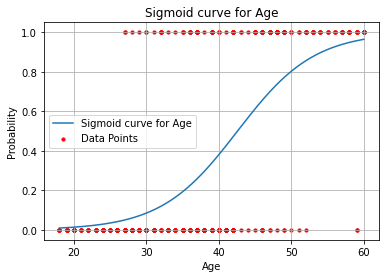

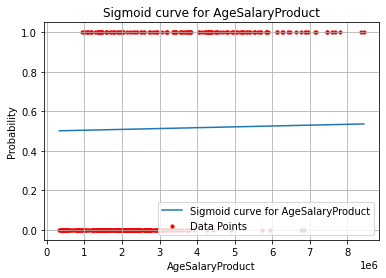

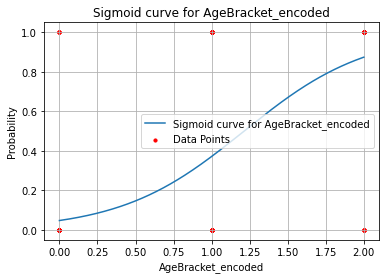

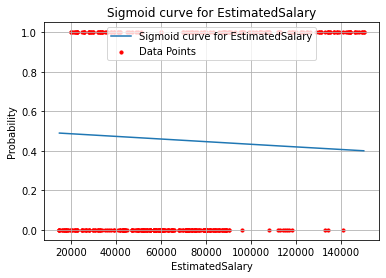

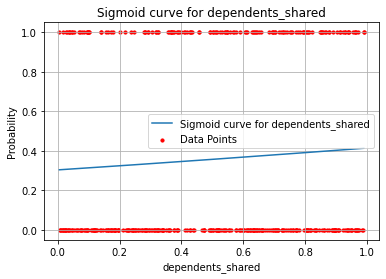

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Function to plot sigmoid curve
def sigmoidcurve(feature, target):
    # Reshape data
    xfeature = feature.values.reshape(-1, 1)
    
    # Train a logistic regression model
    clf = LogisticRegression()
    clf.fit(xfeature, target)
    
    # Create a range of values for the feature
    x_test = np.linspace(feature.min(), feature.max(), 300)
    
    # Predict the probabilities
    y_prob = clf.predict_proba(x_test.reshape(-1, 1))[:, 1]
    
    # Plot
    plt.plot(x_test, y_prob, label=f'Sigmoid curve for {feature.name}')
    plt.scatter(xfeature, target, color='red', s=10, label='Data Points')
    plt.xlabel(feature.name)
    plt.ylabel('Probability')
    plt.title(f'Sigmoid curve for {feature.name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot sigmoid curve for each selected feature
for feature in selected_features:
    sigmoidcurve(data[feature], y)


In [6]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = data[selected_features]
y = data['Purchased']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape


((320, 5), (80, 5))

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize Logistic Regression
logreg = LogisticRegression(random_state=42)

# Initialize GridSearchCV with 5-fold cross validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Measure the computational time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Compute the time taken
time_taken = time.time() - start_time

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score, time_taken


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

({'C': 10, 'penalty': 'l1', 'solver': 'liblinear'},
 0.871875,
 0.5493960380554199)

In [8]:
# ({'C': 10, 'penalty': 'l1', 'solver': 'liblinear'},
#  0.871875,
#  0.7822880744934082) # Time taken 

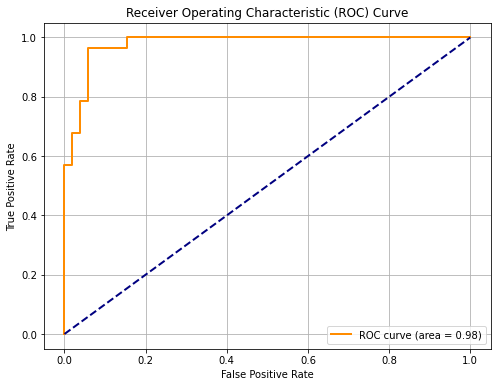

{'Accuracy': 0.95,
 'F1 Score': 0.9310344827586207,
 'ROC AUC Score': 0.978021978021978}

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

# Predict the test set results
y_pred = grid_search.predict(X_test)

# Predict probabilities for ROC curve
y_prob = grid_search.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Get ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'ROC AUC Score': roc_auc
}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

metrics


In [10]:
# SVM 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from time import time

# Splitting the data into features and target variable
X = data[['Age', 'AgeSalaryProduct', 'EstimatedSalary', 'dependents_shared']]
y = data['Purchased']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardizing the features (It's generally a good practice when working with SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training an SVM classifier
clf = SVC(probability=True)  # Using probability=True to compute ROC AUC later
start_time = time()
clf.fit(X_train, y_train)
end_time = time()

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# Performance metrics on test set
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
training_time = end_time - start_time

accuracy, f1, roc_auc, training_time


(0.94, 0.923076923076923, 0.9794079794079794, 0.014018058776855469)

In [ ]:
# Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,5],
    'min_samples_leaf': [2,5]
}

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier()

# Grid search with 5-fold cross validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_params


{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

({'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 4,
  'min_samples_split': 5},
 0.8766666666666666,
 0.8112166780587833,
 0.9272464114832536,
 0.91,
 0.88,
 0.9317889317889317)

NameError: name 'k' is not defined